In [200]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np

from dataset import spiral
# from common.functions import softmax,cross_entropy_error

In [201]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

def cross_entropy_error(y,t):
    if y.ndim == 1:
        t = t.reshape(1,t.size)
        y = y.reshape(1,y.size)
        
    if t.size == y.size:
        t = t.argmax(axis = 1)
    batch_size = y.shape[0]
    
    return -np.sum(np.log(y[np.arange(batch_size),t] +1e-7)) /batch_size

In [202]:
class Affine:
    def __init__(self,W,b):
        self.grads=[np.zeros_like(W),np.zeros_like(b)]
        self.params=[W,b]
        self.x = None

    def forward(self,x):
        W,b=self.params
        out=np.dot(x,W)+b
        self.x = x
        return out

    def backward(self,dout):
        W,b = self.params
        dx=np.dot(dout,W.T)
        dW=np.dot(self.x.T,dout)
        db=np.sum(dout,axis=0)

        self.grads[0][...]=dW
        self.grads[1][...] = db
        return dx

In [203]:
class Sigmoid:
    def __init__(self):
        self.params,self.grads = [],[]
        self.out = None  # 初始化为 None

    def forward(self,x):
        out = 1/(1+np.exp(-x))
        self.out = out
        return out
    
    def backward(self,dout):
        dx = dout*(1.0 - self.out)*self.out
        return dx

In [204]:
class SGD:
    def __init__(self,lr=0.01):
        self.lr = lr

    def update(self,params,grads):
        for i in range(len(params)):
            params[i] -= self.lr*grads[i] 

In [205]:
class SoftmaxWithLoss:
    def __init__(self):
        self.params,self.grads = [],[]
        self.y = None #softmax的输出
        self.t = None #监督标签
        
    def forward(self,x,t):
        self.t =t
        self.y = softmax(x)
        
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)
        
        loss = cross_entropy_error(self.y,self.t)
        return loss
    
    def backward(self,dout=1):
        batch_size = self.t.shape[0]
        
        dx = self.y.copy()
        
        dx[np.arange(batch_size),self.t] -=1
        dx *=dout
        dx = dx/batch_size
        
        return dx

In [206]:
class TwoLayerNet:
    def __init__(self,input_size,hidden_size,output_size):
        I,H,O = input_size,hidden_size,output_size

        # 初始化权重和偏置
        W1 = np.random.randn(I,H)
        b1=np.random.randn(H)
        W2 = np.random.randn(H,O)
        b2=np.random.randn(O)

        # 生成层
        self.layers=[
            Affine(W1,b1),
            Sigmoid(),
            Affine(W2,b2)
        ]

        self.loss_layer = SoftmaxWithLoss()
        
        # 将所有的权重整理到列表中
        self.params,self.grads = [],[]
        for layer in self.layers:
            self.params+=layer.params
            self.grads+=layer.grads

    def predict(self,x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def forward(self,x,t):
        score = self.predict(x)
        loss=self.loss_layer.forward(score,t)
        return loss

    def backward(self,dout=1):
        dout=self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

In [207]:
max_epoch = 300
batch_size=30
hidden_size=10
learning_rate=1.0

x,t = spiral.load_data()
model = TwoLayerNet(input_size=2,hidden_size=hidden_size,output_size=3)
optimizer = SGD(lr=learning_rate)

#学习用的变量
data_size = len(x)
max_iters = data_size//batch_size
total_loss = 0
loss_count = 0
loss_list = []


In [208]:
for epoch in range(max_epoch):
    idx = np.random.permutation(data_size)
    x = x[idx]
    t = t[idx]

    for iters in range(max_iters):
        batch_x = x[iters*batch_size:(iters+1)*batch_size]
        batch_t = t[iters*batch_size:(iters+1)*batch_size]

        # print(batch_x,batch_t)
        loss = model.forward(batch_x,batch_t)
        model.backward()
        optimizer.update(model.params,model.grads)
        total_loss +=loss
        loss_count +=1

        if(iters+1)%10==0:
            avg_loss = total_loss /loss_count
            print('| epoch %d | iter %d / %d| loss %.2f'%(epoch+1,iters+1,max_iters,avg_loss))
            loss_list.append(avg_loss)
            total_loss,loss_count =0,0

| epoch 1 | iter 10 / 10| loss 1.23
| epoch 2 | iter 10 / 10| loss 1.09
| epoch 3 | iter 10 / 10| loss 0.97
| epoch 4 | iter 10 / 10| loss 0.89
| epoch 5 | iter 10 / 10| loss 0.88
| epoch 6 | iter 10 / 10| loss 0.83
| epoch 7 | iter 10 / 10| loss 0.81
| epoch 8 | iter 10 / 10| loss 0.78
| epoch 9 | iter 10 / 10| loss 0.79
| epoch 10 | iter 10 / 10| loss 0.80
| epoch 11 | iter 10 / 10| loss 0.79
| epoch 12 | iter 10 / 10| loss 0.78
| epoch 13 | iter 10 / 10| loss 0.77
| epoch 14 | iter 10 / 10| loss 0.75
| epoch 15 | iter 10 / 10| loss 0.79
| epoch 16 | iter 10 / 10| loss 0.75
| epoch 17 | iter 10 / 10| loss 0.74
| epoch 18 | iter 10 / 10| loss 0.73
| epoch 19 | iter 10 / 10| loss 0.75
| epoch 20 | iter 10 / 10| loss 0.74
| epoch 21 | iter 10 / 10| loss 0.75
| epoch 22 | iter 10 / 10| loss 0.73
| epoch 23 | iter 10 / 10| loss 0.74
| epoch 24 | iter 10 / 10| loss 0.76
| epoch 25 | iter 10 / 10| loss 0.75
| epoch 26 | iter 10 / 10| loss 0.72
| epoch 27 | iter 10 / 10| loss 0.74
| epoch 28

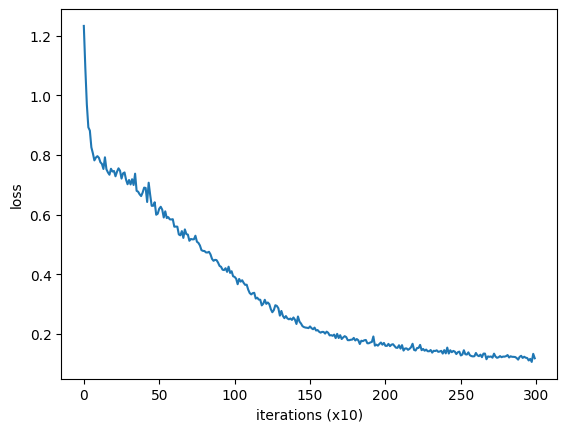

In [209]:
plt.plot(np.arange(len(loss_list)), loss_list, label='train')
plt.xlabel('iterations (x10)')
plt.ylabel('loss')
plt.show()